In [2]:
import os
import numpy as np
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

In [3]:
# Define the directories and categories
original_dataset_dir = '/Users/code/alzheimerDetect/OriginalDataset'
categories = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Parameters
img_size = 128  # Resize images to 128x128 pixels

In [4]:
# Load images and labels
data = []
labels = []

for category in categories:
    category_path = os.path.join(original_dataset_dir, category)
    class_num = categories.index(category)
    for img in os.listdir(category_path):
        try:
            img_array = cv2.imread(os.path.join(category_path, img), cv2.IMREAD_GRAYSCALE)
            resized_array = cv2.resize(img_array, (img_size, img_size))
            data.append(resized_array)
            labels.append(class_num)
        except Exception as e:
            print(f"Error loading image {img}: {e}")

In [5]:
# Convert lists to numpy arrays and normalize pixel values
data = np.array(data).reshape(-1, img_size, img_size, 1) / 255.0
labels = np.array(labels)

In [6]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten

In [8]:
# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))


2024-08-30 10:08:18.334076: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-08-30 10:08:18.334094: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-30 10:08:18.334098: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-30 10:08:18.334419: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-30 10:08:18.334431: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
# Add a flatten layer to convert the 3D output to 1D
x = Flatten()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=x)

In [10]:
# Extract features for training and testing data
X_train_features = feature_extractor.predict(np.repeat(X_train, 3, axis=-1))
X_test_features = feature_extractor.predict(np.repeat(X_test, 3, axis=-1))

2024-08-30 10:08:21.098349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step


In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [12]:

# Initialize and train the SVM
svm = SVC(kernel='linear')
svm.fit(X_train_features, y_train)

SVC(kernel='linear')

In [13]:
# Predict on the test set
y_pred = svm.predict(X_test_features)

In [14]:
# Print the classification report and accuracy
print(classification_report(y_test, y_pred, target_names=categories))
print("Accuracy:", accuracy_score(y_test, y_pred))

                  precision    recall  f1-score   support

    MildDemented       0.89      0.98      0.93       201
ModerateDemented       1.00      1.00      1.00         6
     NonDemented       0.96      0.93      0.95       643
VeryMildDemented       0.92      0.92      0.92       430

        accuracy                           0.94      1280
       macro avg       0.94      0.96      0.95      1280
    weighted avg       0.94      0.94      0.94      1280

Accuracy: 0.93515625


In [15]:
import joblib

# Save the trained SVM model
joblib.dump(svm, 'svm_cv2_alzheimer_model.pkl')

['svm_cv2_alzheimer_model.pkl']

In [16]:
# Load the saved SVM model
svm_loaded = joblib.load('svm_cv2_alzheimer_model.pkl')

In [17]:
def preprocess_image(image_path, img_size=128):
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_array = cv2.resize(img_array, (img_size, img_size))
    normalized_array = np.array(resized_array).reshape(1, img_size, img_size, 1) / 255.0
    return normalized_array

def extract_features(image_array, feature_extractor):
    return feature_extractor.predict(np.repeat(image_array, 3, axis=-1))

def predict_image(image_path, model, feature_extractor):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)
    
    # Extract features
    features = extract_features(preprocessed_image, feature_extractor)
    
    # Predict using the loaded model
    prediction = model.predict(features)
    
    return prediction

# Predict the class of a new image
image_path = '/Users/arnabsahoo/Downloads/FinalPriject/Alzheimer_s Dataset/test/VeryMildDemented/26 (53).jpg' 
prediction = predict_image(image_path, svm_loaded, feature_extractor)

# Convert the numerical prediction to the corresponding category
predicted_category = categories[prediction[0]]
print("Predicted Category:", predicted_category)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
Predicted Category: VeryMildDemented


In [21]:
import numpy as np
import os
import h5py

# Ensure the data is in the correct format (e.g., RGB images)
data = np.stack([np.repeat(img, 3, axis=-1) for img in data])  # Convert grayscale to RGB if needed

# Extract features using the feature extractor model
features = feature_extractor.predict(data)

# Save the features and labels to disk
output_dir = 'FeatureOutput' 
os.makedirs(output_dir, exist_ok=True)

# Save features to an HDF5 file
features_file = os.path.join(output_dir, 'features.h5')
labels_file = os.path.join(output_dir, 'labels.npy')

with h5py.File(features_file, 'w') as f:
    f.create_dataset('features', data=features)

np.save(labels_file, labels)

print(f"Features and labels saved to {output_dir}")

200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step
Features and labels saved to FeatureOutput


First feature vector: [0.         0.         0.         ... 0.         0.81733423 0.        ]


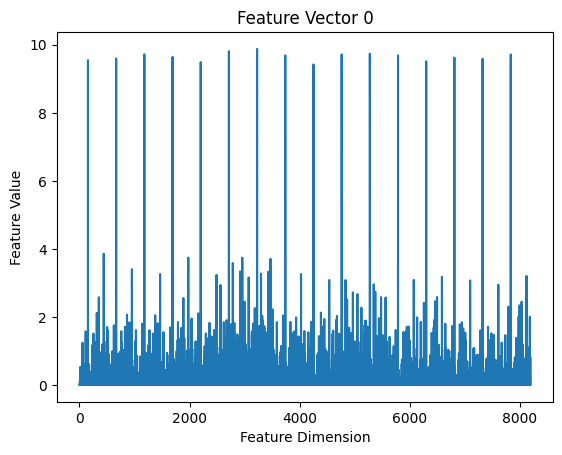

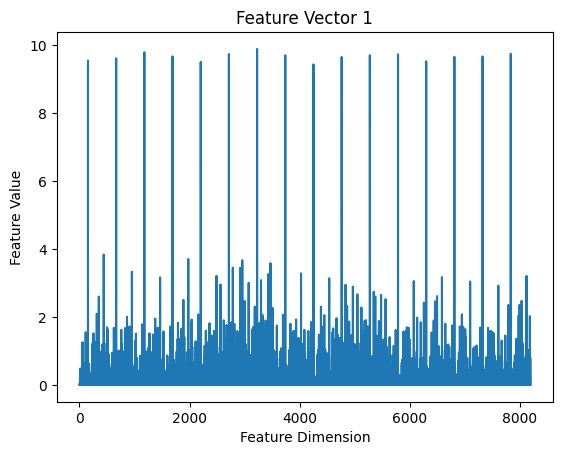

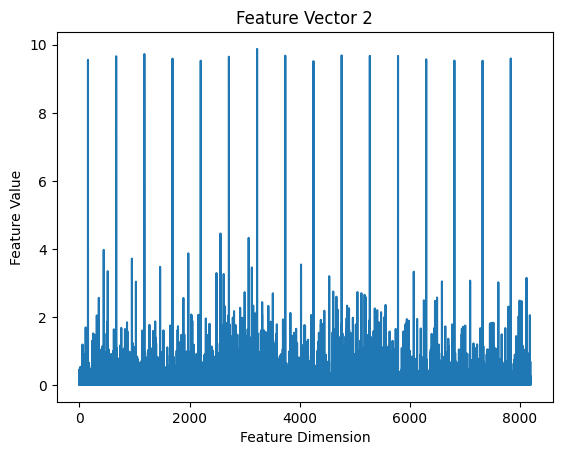

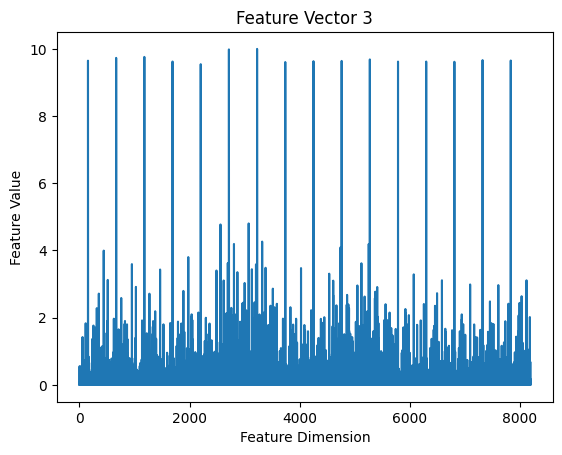

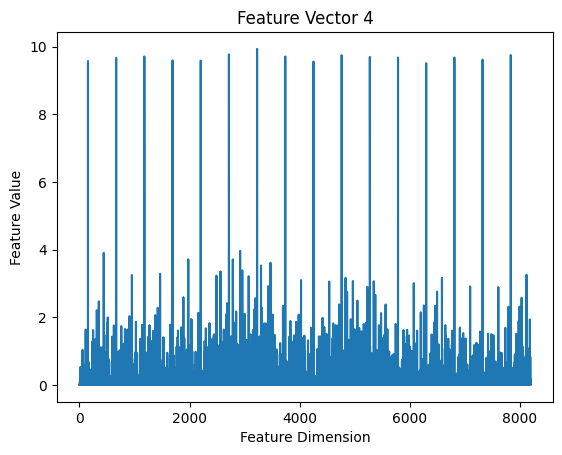

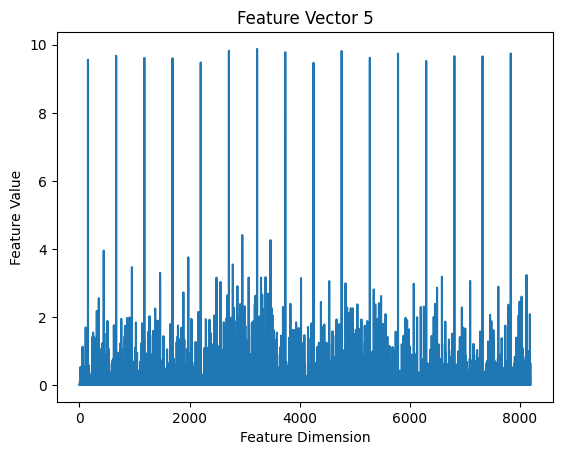

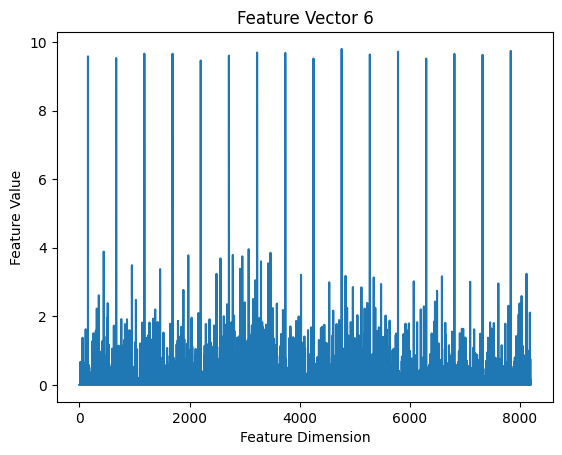

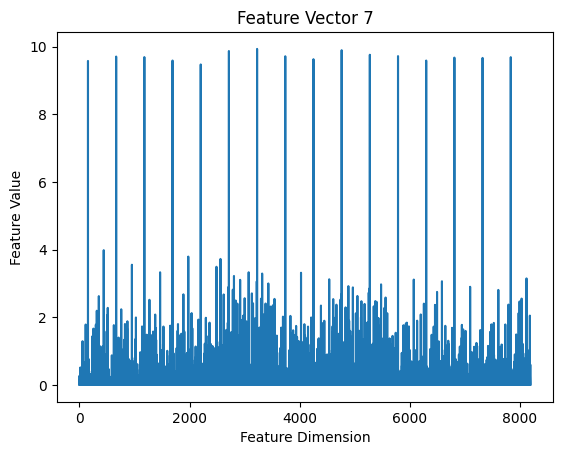

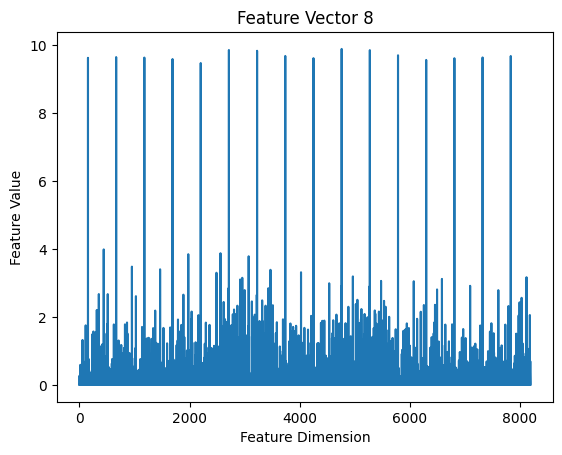

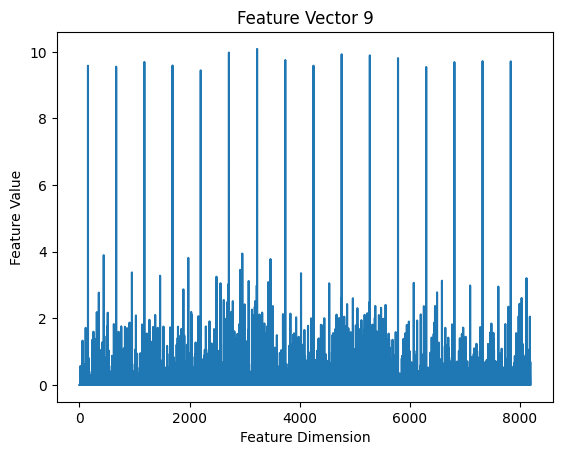

In [23]:
import matplotlib.pyplot as plt

# Load the saved features and labels
with h5py.File(features_file, 'r') as f:
    loaded_features = f['features'][:]

loaded_labels = np.load(labels_file)

# Display the first feature vector
first_feature_vector = loaded_features[0]
print("First feature vector:", first_feature_vector)

# Visualize feature vectors
for i in range(min(10, loaded_features.shape[0])):
    plt.figure()
    plt.plot(loaded_features[i])
    plt.title(f'Feature Vector {i}')
    plt.xlabel('Feature Dimension')
    plt.ylabel('Feature Value')
    plt.show()